In [1]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 11.75 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [12]:
!nvidia-smi

Fri May 12 15:52:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   2187MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.4/428.4 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 11.3 MB/s eta 0:

# Analyzing NYC Taxi Fares with RAPIDS

**RAPIDS** is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, scikit-learn, and Dask.

This notebook builds a simple data pipeline:

we'll use cuDF to load, clean and prep some data, as well as for some feature engineering
we'll use cuML to explore patterns the data using unsupervised learning, and build a simple predictive model on top of it
We'll learn that cuDF and cuML are GPU-accelerated libraries that are very similar to Pandas and scikit-learn (their respective CPU counterparts). The benefit of using RAPIDS libraries like cuDF and cuML is that they are much faster!


In [3]:
import glob
import os

import cupy
import cudf
import cuml
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn
from tqdm.auto import tqdm

The very first operation performed using cuDF initializes the library, which has some overhead. To ensure that this initialization time is not included when we measure code execution time, we "warm up" cuDF before using it for any real work:

In [5]:
_ = cudf.Series([1])  # warmup

#Get the data

The main dataset we'll be using in this notebook comes from the New York City Taxi and Limousine Commision (TLC). The TLC publishes data about taxi rides, including pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data is made available as PARQUET files, and is published monthly.

The code below downloads the PARQUET files containing trip data for "Yellow" Taxis from the year 2021. It also downloads a second, smaller dataset: a CSV file containing geographical information that will be useful in later parts of our analysis.

In [6]:
def download(url, fname):
    """
    Download file from `url`, writing the result to `fname`.
    If `fname` already exists, do nothing.
    """
    # this code adapted from the tqdm examples
    # https://github.com/tqdm/tqdm/blob/master/examples/tqdm_requests.py
    if os.path.exists(fname):
        return
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"),
        "write",
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=fname,
        total=int(response.headers.get("content-length", 0)),
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)


def download_taxi_data(n):
    """
    Download `n` months of taxi data.
    """
    base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
    fname = "yellow_tripdata_2021-{i:02d}.parquet"
    url = base + fname
    for i in range(1, n + 1):
        download(url.format(i=i), fname.format(i=i))


def download_taxi_zones():
    download(
        "https://gist.githubusercontent.com/shwina/72d79165ce9605d8f6e3378ae717b16b/raw/84a47bc587c99c6736f38a97f9dcc32ba8f89b05/taxi_zones.csv",
        "taxi_zones.csv",
    )


# adjust n between 1-12 depending on the size of analysis
download_taxi_data(n=6)
download_taxi_zones()

yellow_tripdata_2021-01.parquet:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

yellow_tripdata_2021-02.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

yellow_tripdata_2021-03.parquet:   0%|          | 0.00/28.6M [00:00<?, ?B/s]

yellow_tripdata_2021-04.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

yellow_tripdata_2021-05.parquet:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

yellow_tripdata_2021-06.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

taxi_zones.csv:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

In [7]:
ls

rapidsai-csp-utils/              yellow_tripdata_2021-03.parquet
sample_data/                     yellow_tripdata_2021-04.parquet
taxi_zones.csv                   yellow_tripdata_2021-05.parquet
yellow_tripdata_2021-01.parquet  yellow_tripdata_2021-06.parquet
yellow_tripdata_2021-02.parquet


#Part 1: Loading and Preparing Data
Our dataset is a collection of Parquet files containing NYC taxi trip data. Another smaller dataset taxi_zones.csv contains some geographical information that we'll use later:

#1.1 Reading the data

First, we'll read the Parquet data into a Pandas dataframe using the pandas.read_parquet() function. Then, we'll see how to do the same thing with cuDF.

In [9]:
# TODO: Use Pandas to read all the parquet files into a variable
# named `df`. Use cUDF to do the same thing, and save the result to a
# variable named `gdf`

df = pd.read_parquet(sorted(list(glob.glob("*.parquet"))))
gdf = cudf.read_parquet(sorted(list(glob.glob("*.parquet"))))

In [10]:
print(type(df))
print(type(gdf))

<class 'pandas.core.frame.DataFrame'>
<class 'cudf.core.dataframe.DataFrame'>


In [11]:
display(df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179185,2,2021-06-30 23:25:00,2021-06-30 23:39:00,NaN,3.27,NaN,None,162,249,0,14.28,0.0,0.5,2.81,0.0,0.3,20.39,NaN,NaN
12179186,2,2021-06-30 23:36:02,2021-07-01 00:05:56,NaN,9.93,NaN,None,217,239,0,32.03,0.0,0.5,7.69,0.0,0.3,43.02,NaN,NaN
12179187,6,2021-06-30 23:06:09,2021-06-30 23:06:45,NaN,7.31,NaN,None,265,76,0,39.50,0.0,0.5,0.00,0.0,0.3,40.30,NaN,NaN
12179188,2,2021-06-30 23:01:24,2021-06-30 23:10:20,NaN,2.83,NaN,None,143,236,0,13.51,0.0,0.5,3.57,0.0,0.3,20.38,NaN,NaN


In [13]:
display(gdf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.0,0.5,0.00,0.0,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.5,0.5,0.00,0.0,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.5,0.5,8.65,0.0,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.5,0.5,6.05,0.0,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.5,0.5,4.06,0.0,0.3,24.36,2.5,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179185,2,2021-06-30 23:25:00,2021-06-30 23:39:00,<NA>,3.27,<NA>,<NA>,162,249,0,14.28,0.0,0.5,2.81,0.0,0.3,20.39,<NA>,<NA>
12179186,2,2021-06-30 23:36:02,2021-07-01 00:05:56,<NA>,9.93,<NA>,<NA>,217,239,0,32.03,0.0,0.5,7.69,0.0,0.3,43.02,<NA>,<NA>
12179187,6,2021-06-30 23:06:09,2021-06-30 23:06:45,<NA>,7.31,<NA>,<NA>,265,76,0,39.50,0.0,0.5,0.00,0.0,0.3,40.30,<NA>,<NA>
12179188,2,2021-06-30 23:01:24,2021-06-30 23:10:20,<NA>,2.83,<NA>,<NA>,143,236,0,13.51,0.0,0.5,3.57,0.0,0.3,20.38,<NA>,<NA>


**A few things to note:**

cuDF offers a Pandas-like API. It doesn't require you to learn a new library to take advantage of the GPU.
cuDF has a cudf.DataFrame type that is analogous to pd.DataFrame. The primary difference between the two is that cudf.DataFrame lives on the GPU and any operations on it utilize the GPU rather than the CPU (and are hence much faster)

#1.2 Data Cleanup
Next, we're going to do some preliminary cleanup of our data.

We've defined a helper function called clean_columns below. This helper function accepts a Pandas DataFrame as its first parameter, and does four things:

Converts the column names to all lowercase, and removes any extraneous spaces in the column names.
Discards columns that we won't use in our analysis.
Casts columns to the appropriate data type.
Replace missing values ("nulls") in columns with a sentinel value -1.
In particular, note the operations invoked on the input DataFrame df:

- df.columns
- df.rename
- df.drop
- df[] (indexing operation returning a Series)
- Series.fillna()
- Series.asype()

In [14]:
def clean_columns(df, columns_to_keep, column_renames):
    """
    Perform column cleanup on the input DataFrame `df`.
    Drop any columns not present in `columns_to_keep`.
    Then, rename columns according to the mapping `column_renames`.
    Finally, cast any numeric columns from 64-bit to 32-bit data types,
    while filling any nulls that may be present with the sentinel
    value -1.
    
    Parameters
    ----------
    df: DataFrame
        Input dataframe
    columns_to_keep: list
        List of columns to keep in the result
    column_renames: dict
        Mapping that specifies the column renaming to apply

    Returns
    -------
    DataFrame
    """
    # rename columns
    colname_cleanup = {col: col.strip().lower() for col in df.columns}
    df = df.rename(columns=colname_cleanup)
    df = df.rename(column_renames, axis=1)

    # Simplify the payment_type column
    df["is_credit_card"] = df["payment_type"] == 1

    # Drop unwanted columns, and cast data down from
    # 64-bit type to 32-bit type when possible
    for col in df.columns:
        if col not in columns_to_keep:
            print(f"Dropping ({col})")
            df = df.drop(columns=col)
            continue

        # cast int64->int32, float64->float32
        # and fill nulls with -1
        dtype = df[col].dtype
        if dtype.kind in {"i", "f"}:
            if dtype.itemsize == 8:
                df[col] = df[col].astype(dtype.kind + str(dtype.itemsize))
            df[col] = df[col].fillna(-1)

    return df

Now, let's call the clean_columns on our Pandas dataframe df:

In [15]:
%%time

columns_to_keep = [
    "pickup_datetime",
    "dropoff_datetime",
    "passenger_count",
    "pickup_longitude",
    "pickup_latitude",
    "rate_code",
    "fare_amount",
    "pickup_location",
    "dropoff_location",
    "is_credit_card",
    "airport_fee",
]

column_renames = {
    "tpep_pickup_datetime": "pickup_datetime",
    "tpep_dropoff_datetime": "dropoff_datetime",
    "ratecodeid": "rate_code",
    "pulocationid": "pickup_location",
    "dolocationid": "dropoff_location",
}

df = clean_columns(df, columns_to_keep, column_renames)
display(df.head())

Dropping (vendorid)
Dropping (trip_distance)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,1.0,138,132,29.0,-1.0,True
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True


CPU times: user 5.19 s, sys: 9.22 s, total: 14.4 s
Wall time: 14.4 s


**What about gdf?**

How can we do the same cleanup on gdf as we did with df? Do we need to define a new helper function that can work with cuDF DataFrames?

In [16]:
%%time
# TODO: do the same cleanup on `gdf` as we did with `df`

gdf = clean_columns(gdf, columns_to_keep, column_renames)
display(gdf.head())

Dropping (vendorid)
Dropping (trip_distance)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,1.0,138,132,29.0,-1.0,True
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True


CPU times: user 273 ms, sys: 315 ms, total: 588 ms
Wall time: 779 ms


Notice that clean_columns can be used with a cuDF DataFrame without any changes! This is because cuDF DataFrames support many of the same operations (like drop, rename, astype, fillna) as Pandas DataFrames.

**1.3 Visualizing and filtering the data**


The next step in our analysis is to identify any statistical anomalies in the data, e.g., data that was entered incorrectly due to human error?

Data Visualization is a great tool to find these kinds of issues.

As an example, we'll use the Seaborn library to make a boxplot from our data, which will show us the outliers in the dataset.

Seaborn does not currently support cuDF DataFrames as input, so we need to use the .to_pandas() method to convert to a Pandas DataFrame before passing it to Seaborn.

For a more general guide on how to use RAPIDS with most of the popular visualization libraries, see the viz gallery in our docs: https://docs.rapids.ai/visualization

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

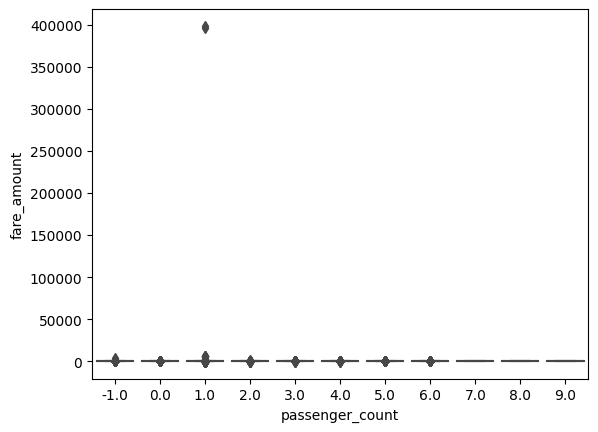

In [17]:
# TODO: using the cuDF DataFrame gdf, make a boxplot
# of the fare_amount to passenger_count using seaborn

sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

The dataset clearly has some significant outliers. Let's filter the data to throw out some of the outliers and also to remove missing values:

In [18]:
query_frags = [
    "fare_amount > 0",
    "fare_amount < 500",
    "passenger_count > 0",
    "passenger_count < 6",
]
query = " and ".join(query_frags)
display(query)

'fare_amount > 0 and fare_amount < 500 and passenger_count > 0 and passenger_count < 6'

In [19]:
# TODO: apply the query above to the DataFrame `gdf`
# remember to reset the index afterwards.
# (any time you filter the dataframe, it's a good idea to reset its index)


gdf = gdf.query(query)
gdf = gdf.reset_index(drop=True)

# inspect the results of cleaning
display(gdf)

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True
...,...,...,...,...,...,...,...,...,...
10970246,2021-06-30 23:06:57,2021-06-30 23:17:00,1.0,1.0,230,141,9.5,0.0,True
10970247,2021-06-30 23:46:10,2021-06-30 23:56:13,1.0,1.0,230,158,9.5,0.0,True
10970248,2021-06-30 23:16:57,2021-06-30 23:24:52,1.0,1.0,90,107,7.0,0.0,True
10970249,2021-06-30 23:35:03,2021-06-30 23:40:57,1.0,1.0,249,231,6.5,0.0,True


<Axes: xlabel='passenger_count', ylabel='fare_amount'>

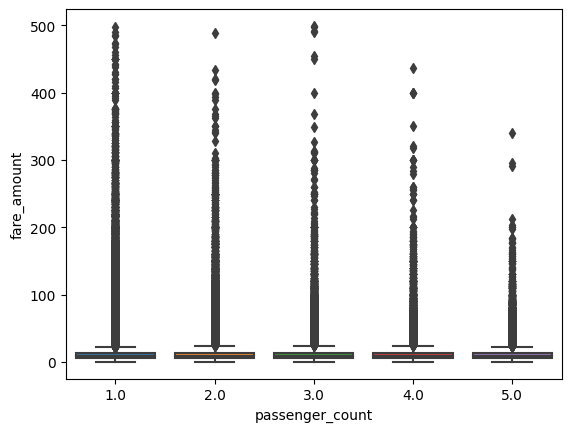

In [21]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

#1.4 Takeaways

cuDF offers similar classes, functions, and methods to Pandas
This includes functions for reading and writing data!
cuDF DataFrames and other objects utilize GPU memory (rather than CPU memory or "RAM")
Code that is written to use Pandas can easily be changed to use cuDF instead
You can use cuDF with third-party libraries that work with Pandas, using the .to_pandas() and .from_pandas() functions
By virtue of using the GPU, cuDF can be much faster than Pandas

Now that we've gotten rid of the more obvious outliers, we can continue with the rest of the analysis.